In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [47]:
profit = pd.read_csv('G2M_Case_study_finalds.csv', usecols=['Date', 'Company', 'Profit'], parse_dates=['Date'])

In [48]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     359392 non-null  datetime64[ns]
 1   Company  359392 non-null  object        
 2   Profit   359392 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.2+ MB


In [49]:
profit = profit.set_index('Date')

In [50]:
yellow_cab_profit = profit[profit['Company'] == 'Yellow Cab']
pink_cab_profit = profit[profit['Company'] == 'Pink Cab']

In [51]:
yellow_cab_profit_monthly = yellow_cab_profit.resample('M').mean()
pink_cab_profit_monthly = pink_cab_profit.resample('M').mean()

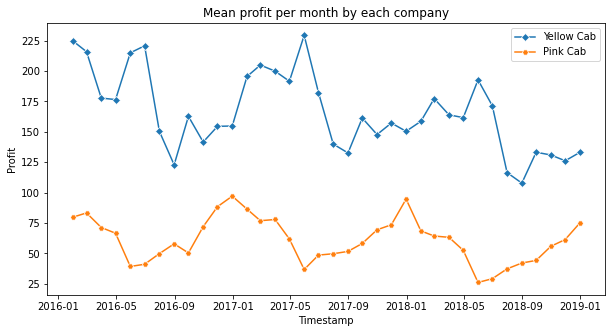

In [52]:
plt.figure(figsize = (10,5))
sns.lineplot(x=yellow_cab_profit_monthly.index, y='Profit', data=yellow_cab_profit_monthly, marker='D')
sns.lineplot(x=pink_cab_profit_monthly.index, y='Profit', data=pink_cab_profit_monthly, marker='H')
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.title('Mean profit per month by each company')
plt.xlabel('Timestamp')
#plt.savefig('meanprofit_per_month.png')
plt.show()

In [53]:
import statsmodels.api as sm
y = yellow_cab_profit_monthly['Profit']
# graphs to show seasonal_decompose
def seasonal_decompose (y, name):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.savefig(name)
    plt.show()

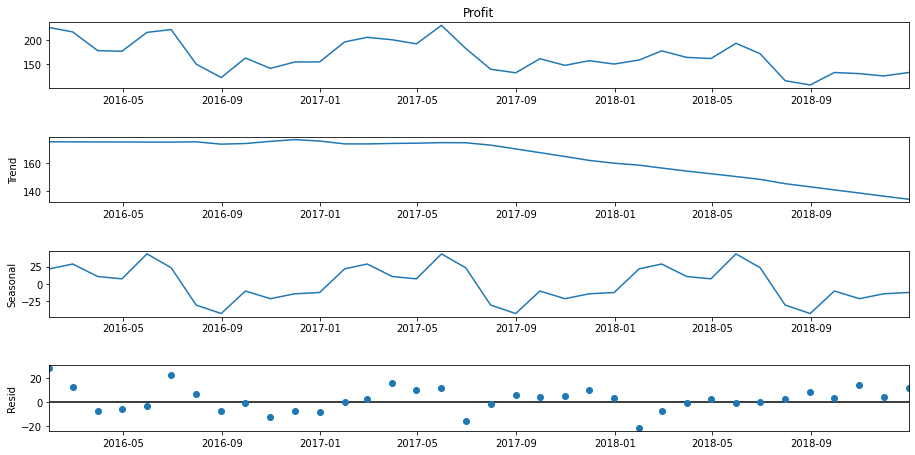

In [54]:
seasonal_decompose(y, 'seasonal_yellow_cab.png')

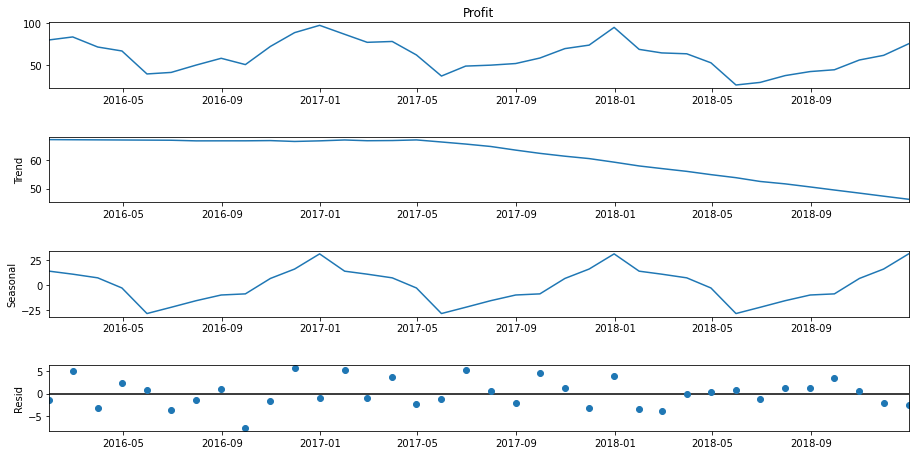

In [55]:
y2 = pink_cab_profit_monthly['Profit']
seasonal_decompose(y2, 'seasonal_pink_cab.png')

# Checking for Stationarity

In [56]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7, min_periods=1).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7, min_periods=1).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

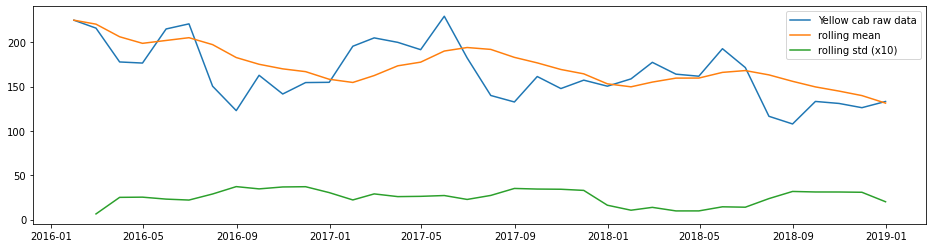

In [57]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'Yellow cab raw data')

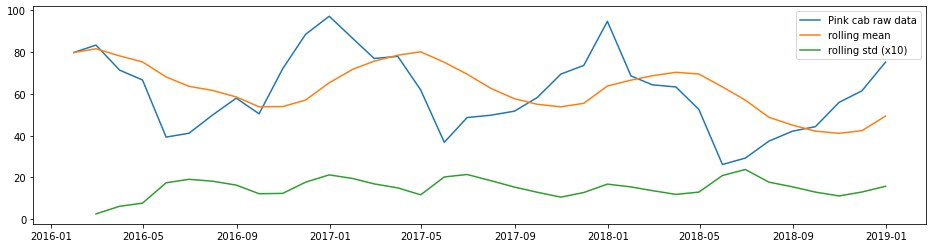

In [58]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y2,'Pink cab raw data')

In [59]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [60]:
ADF_test(y,'Yellow cab raw data')

 > Is the Yellow cab raw data stationary ?
Test statistic = 0.135
P-value = 0.968
Critical values :
	1%: -3.7238633119999998 - The data is not stationary with 99% confidence
	5%: -2.98648896 - The data is not stationary with 95% confidence
	10%: -2.6328004 - The data is not stationary with 90% confidence


In [61]:
ADF_test(y2,'Pink raw data')

 > Is the Pink raw data stationary ?
Test statistic = 1.067
P-value = 0.995
Critical values :
	1%: -3.6996079738860943 - The data is not stationary with 99% confidence
	5%: -2.9764303469999494 - The data is not stationary with 95% confidence
	10%: -2.627601001371742 - The data is not stationary with 90% confidence


### Conclusion: Both time series are not stationary

 > Is the de-trended data stationary ?
Test statistic = -5.504
P-value = 0.000
Critical values :
	1%: -3.8092091249999998 - The data is  stationary with 99% confidence
	5%: -3.0216450000000004 - The data is  stationary with 95% confidence
	10%: -2.6507125 - The data is  stationary with 90% confidence


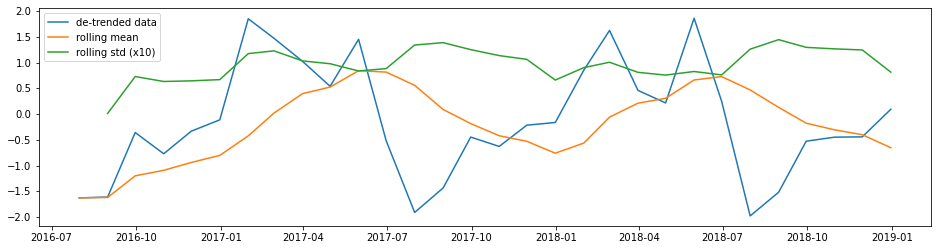

In [62]:
# Detrending
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the de-trended data stationary ?
Test statistic = -5.504
P-value = 0.000
Critical values :
	1%: -3.8092091249999998 - The data is  stationary with 99% confidence
	5%: -3.0216450000000004 - The data is  stationary with 95% confidence
	10%: -2.6507125 - The data is  stationary with 90% confidence


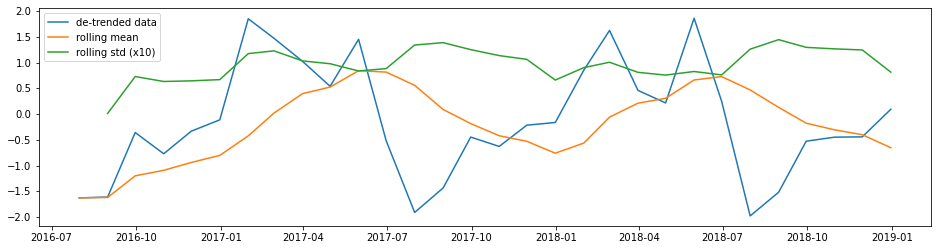

In [63]:
# Detrending
y2_detrend =  (y2 - y2.rolling(window=7).mean())/y2.rolling(window=7).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

In [73]:
train_size=int(len(y_detrend) *0.7) # 70% for training
test_size = int(len(y_detrend)) - train_size

train_y = y_detrend[:train_size].dropna()
test_y = y_detrend[train_size:].dropna()

In [78]:
train_y.head()

Date
2016-07-31   -1.62819851
2016-08-31   -1.61164431
2016-09-30   -0.35938076
2016-10-31   -0.77173906
2016-11-30   -0.33278808
Freq: M, Name: Profit, dtype: float64

In [74]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [77]:
sarima_grid_search(y_detrend,3)

The set of parameters with the minimum AIC is: SARIMA(0, 0, 1)x(0, 0, 0, 3) - AIC:81.55627887560362


In [67]:
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5671      0.221      2.561      0.010       0.133       1.001
ar.S.L7       -0.2304      0.276     -0.836      0.403      -0.770       0.310
ma.S.L7       -1.0000      0.337     -2.964      0.003      -1.661      -0.339
sigma2       611.1582      0.001   1.11e+06      0.000     611.157     611.159


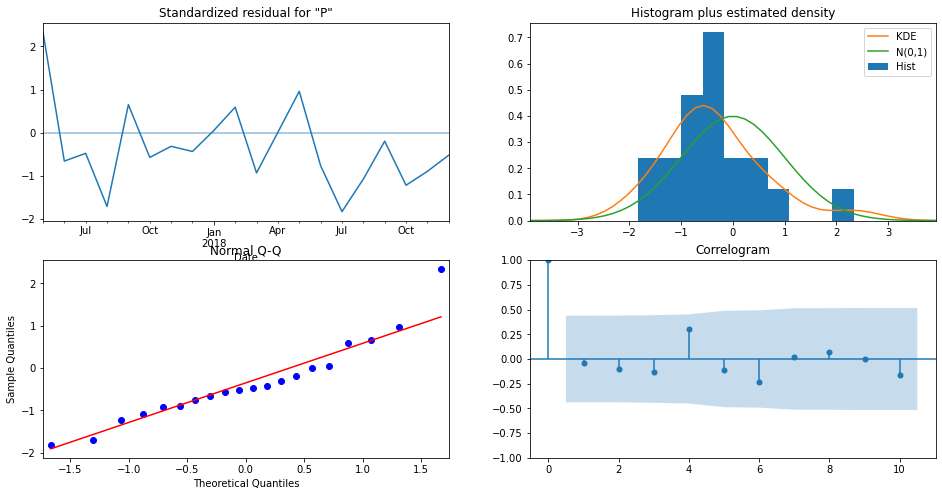

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = False nan


TypeError: invalid type promotion

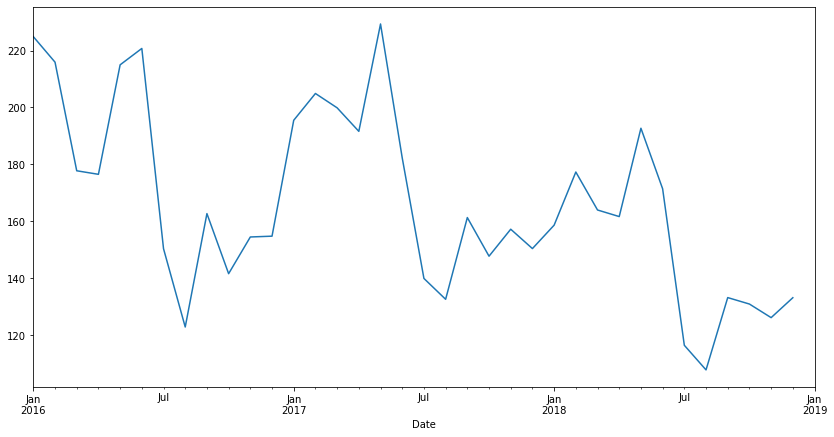

In [79]:
model = sarima_eva(y,(0, 0, 1),(1, 1, 1, 7),7,'2019-01-01',test_y)